In [27]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from safe.tokenizer import SAFETokenizer
from safe.trainer.model import SAFEDoubleHeadsModel
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import os
from molfeat.trans.pretrained.hf_transformers import HFModel
import datamol as dm
import safe as sf

In [28]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [29]:
# Load the trained model and tokenizer
model_checkpoint = "./checkpoint-1712000"
safe_model = SAFEDoubleHeadsModel.from_pretrained(model_checkpoint)

In [30]:
model_tokenizer = "./tokenizer.json"
safe_tokenizer = SAFETokenizer.from_pretrained(model_tokenizer)

In [5]:
# # Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
safe_model.to(device)

SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 512)
    (wpe): Embedding(1024, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPT2Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=512, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=512, out_features=128, bias=True)
    (

In [6]:
designer = sf.SAFEDesign.load_default(verbose=True)

designer.model

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)
    

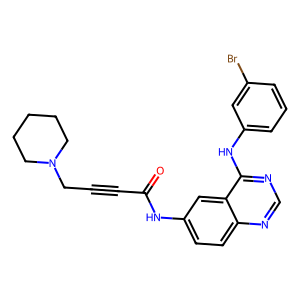

In [7]:
candidate_smiles = "O=C(C#CCN1CCCCC1)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1"
candidate_mol = dm.to_mol(candidate_smiles)

dm.to_image(candidate_mol)

In [8]:
designer = sf.SAFEDesign(
    model=safe_model,
    tokenizer=safe_tokenizer,
    verbose=True,
)

In [9]:
generated_smiles = designer.de_novo_generation(sanitize=True, n_samples_per_trial=10000, early_stopping=False)

  0%|          | 0/1 [00:00<?, ?it/s]

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - Pand

In [10]:
from rdkit.Chem import QED, Crippen
from rdkit import DataStructs
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer

In [11]:
def calculate_diversity(molecules, radius=2, nBits=2048):
    fingerprints = []
    for mol in molecules:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        fingerprints.append(fp)
    
    diversity = 0
    n = len(fingerprints)
    for i in range(n):
        for j in range(i + 1, n):
            similarity = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            diversity += 1 - similarity
    
    if n > 1:
        diversity /= (n * (n - 1) / 2)  # Normalize by the number of pairwise comparisons
    else:
        diversity = 0  # If only one molecule, diversity is zero
    
    return diversity

In [12]:
def evaluate_generated_molecules(generated_smiles):
    valid_mols = []
    unique_smiles = set()
    qed_scores = []
    sas_scores = []
    
    for smi in generated_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_mols.append(mol)
            unique_smiles.add(Chem.MolToSmiles(mol))
            qed_scores.append(QED.qed(mol))
            sas_scores.append(sascorer.calculateScore(mol))
    
    validity = len(valid_mols) / len(generated_smiles) if generated_smiles else 0
    uniqueness = len(unique_smiles) / len(generated_smiles) if generated_smiles else 0
    diversity = calculate_diversity(valid_mols)
    qed_mean = sum(qed_scores) / len(qed_scores) if qed_scores else 0
    sas_mean = sum(sas_scores) / len(sas_scores) if sas_scores else 0
    
    return {
        "validity": validity,
        "uniqueness": uniqueness,
        "diversity": diversity,
        "qed_mean": qed_mean,
        "sas_mean": sas_mean,
    }

In [13]:
evaluation_results = evaluate_generated_molecules(generated_smiles)

In [14]:
print(f"Validity of paper is 1, computed is {evaluation_results['validity']}")
print(f"Uniqueness of paper is 0.999, computed is {evaluation_results['uniqueness']}")
print(f"Diversity of paper is 0.864, computed is {evaluation_results['diversity']}")
print(f"QED mean is {evaluation_results['qed_mean']}")
print(f"SAS mean is {evaluation_results['sas_mean']}")

Validity of paper is 1, computed is 1.0
Uniqueness of paper is 0.999, computed is 0.998896579396128
Diversity of paper is 0.864, computed is 0.8654041163360857
QED mean is 0.8017938199281026
SAS mean is 2.4877209476063795


In [15]:
# Save to safe_small_results.txt
with open("safe_small_results.txt", "w") as f:
    f.write(f"Validity of paper is 1, computed is {evaluation_results['validity']}\n")
    f.write(f"Uniqueness of paper is 0.999, computed is {evaluation_results['uniqueness']}\n")
    f.write(f"Diversity of paper is 0.864, computed is {evaluation_results['diversity']}\n")
    f.write(f"QED mean is {evaluation_results['qed_mean']}\n")
    f.write(f"SAS mean is {evaluation_results['sas_mean']}\n")

More nuanced evaluation

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors, Lipinski
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# Load MOSES test set
moses_test = pd.read_csv('test.csv')
moses_smiles = moses_test['SMILES'].tolist()

In [42]:
def smiles_to_mol(smiles_list):
    return [Chem.MolFromSmiles(smi) for smi in smiles_list if Chem.MolFromSmiles(smi) is not None]

In [43]:
generated_mols = smiles_to_mol(generated_smiles)
moses_mols = smiles_to_mol(moses_smiles)

In [44]:
def calculate_properties(mol_list):
    properties = {
        'MW': [], 'LogP': [], 'HBD': [], 'HBA': [], 'TPSA': [], 'RotBonds': [], 'QED': []
    }
    for mol in mol_list:
        properties['MW'].append(Descriptors.ExactMolWt(mol))
        properties['LogP'].append(Crippen.MolLogP(mol))
        properties['HBD'].append(Lipinski.NumHDonors(mol))
        properties['HBA'].append(Lipinski.NumHAcceptors(mol))
        properties['TPSA'].append(Descriptors.TPSA(mol))
        properties['RotBonds'].append(rdMolDescriptors.CalcNumRotatableBonds(mol))
        properties['QED'].append(Descriptors.qed(mol))
    return properties

In [45]:
generated_properties = calculate_properties(generated_mols)
moses_properties = calculate_properties(moses_mols)

In [ ]:
def plot_property_distributions(gen_props, ref_props, property_name, xlabel, ylabel="Density"):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(gen_props, shade=True, label='Generated', color='blue')
    sns.kdeplot(ref_props, shade=True, label='MOSES', color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'Distribution of {property_name}')
    plt.legend()
    plt.savefig(f'{property_name.lower().replace(" ", "_")}_distribution.png')
    plt.close()

In [ ]:
properties_to_plot = [
    ('MW', 'Molecular Weight', 'Molecular Weight (Da)'),
    ('LogP', 'LogP', 'LogP'),
    ('HBD', 'H-Bond Donors', 'Number of H-Bond Donors'),
    ('HBA', 'H-Bond Acceptors', 'Number of H-Bond Acceptors'),
    ('TPSA', 'Topological Polar Surface Area', 'TPSA (Å²)'),
    ('RotBonds', 'Rotatable Bonds', 'Number of Rotatable Bonds'),
    ('QED', 'QED', 'Quantitative Estimate of Drug-likeness')
]

for prop, name, xlabel in properties_to_plot:
    plot_property_distributions(generated_properties[prop], moses_properties[prop], name, xlabel)

In [ ]:
def print_summary_stats(gen_props, ref_props):
    print("Property\tGenerated (mean ± std)\tMOSES (mean ± std)")
    for prop, name, _ in properties_to_plot:
        gen_mean, gen_std = np.mean(gen_props[prop]), np.std(gen_props[prop])
        ref_mean, ref_std = np.mean(ref_props[prop]), np.std(ref_props[prop])
        print(f"{name}\t{gen_mean:.2f} ± {gen_std:.2f}\t{ref_mean:.2f} ± {ref_std:.2f}")

In [ ]:
print_summary_stats(generated_properties, moses_properties)

scaffold analysis

In [ ]:
from rdkit.Chem.Scaffolds import MurckoScaffold

In [ ]:
def analyze_scaffolds(mol_list):
    scaffolds = {}
    for mol in mol_list:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        scaffold_smiles = Chem.MolToSmiles(scaffold)
        scaffolds[scaffold_smiles] = scaffolds.get(scaffold_smiles, 0) + 1
    return scaffolds

In [ ]:
generated_scaffolds = analyze_scaffolds(generated_mols)
moses_scaffolds = analyze_scaffolds(moses_mols)

In [ ]:
print(f"Unique scaffolds in generated set: {len(generated_scaffolds)}")
print(f"Unique scaffolds in MOSES set: {len(moses_scaffolds)}")

In [ ]:
# Scaffold diversity
gen_scaffold_diversity = len(generated_scaffolds) / len(generated_mols)
moses_scaffold_diversity = len(moses_scaffolds) / len(moses_mols)

print(f"Scaffold diversity in generated set: {gen_scaffold_diversity:.4f}")
print(f"Scaffold diversity in MOSES set: {moses_scaffold_diversity:.4f}")

Novelty Assessment

In [ ]:
def calculate_novelty(gen_mols, ref_mols, similarity_threshold=0.4):
    ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in ref_mols]
    
    novel_count = 0
    for gen_mol in gen_mols:
        gen_fp = AllChem.GetMorganFingerprintAsBitVect(gen_mol, 2, nBits=2048)
        max_similarity = max(DataStructs.TanimotoSimilarity(gen_fp, ref_fp) for ref_fp in ref_fps)
        if max_similarity < similarity_threshold:
            novel_count += 1
    
    novelty = novel_count / len(gen_mols)
    return novelty

In [ ]:
novelty = calculate_novelty(generated_mols, moses_mols)
print(f"Novelty: {novelty:.4f}")